In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
from torch.utils.data.sampler import WeightedRandomSampler
from learning_tool import *
import sys
sys.path.append('..')

from model.model import *

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device('cpu')

cuda:0


In [5]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# 乱数初期化
torch_seed()

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values
        
    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.LongTensor(self.features_values[idx])
        labels = torch.as_tensor(self.labels[idx])
        return features_x, labels

In [7]:
# 出力次元数
# 分類先クラス数　今回は2になる
n_output = 2

# 隠れ層のノード数
n_hidden = 100

# 結果確認
print(f'n_hidden: {n_hidden} n_output: {n_output}')

n_hidden: 100 n_output: 2


In [8]:
net = CNN(n_output, n_hidden).to(device)
print(net)

CNN(
  (relu): ReLU(inplace=True)
  (embedding): Embedding(2001, 128)
  (conv1): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(1998, 1), stride=(1998, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 128, kernel_size=(4, 128), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(1997, 1), stride=(1997, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(1, 128, kernel_size=(5, 128), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(1996, 1), stride=(1996, 1), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=384, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (features1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1998, 1), stride=(1998, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (features2): Sequential(
    (0): Conv2d(1, 128, kernel_

In [9]:
def make_weighted_random_sampler(train_set):
    numDataPoints = len(train_set)
    data_dim = len(train_set[0][0])

    data = torch.FloatTensor(numDataPoints, data_dim)
    target = np.zeros(0)
    target = (np.hstack(data[1].numpy() for data in train_set))
    # target
    # print(target)
    print ('target train 0/1: {}/{}'.format(
        len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])

    samples_weight = torch.from_numpy(samples_weight)
    samples_weight = samples_weight.double()
    # print(samples_weight)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    return sampler

In [10]:
def make_dataset(filename):
    df = pd.read_csv(filename, index_col=0)
    columns = df.columns.values
    features_columns = columns[:-1]
    labels_column = columns[-1]
    dataset = MyDataset(df, features_columns, labels_column)
    return dataset

In [11]:
def record_history(df, filename, seed, each_history, num_splits):
    # print(df)
    score_type = ['train_loss','train_acc','test_loss','test_acc','auc_score']
    for num_kf in range(num_splits):
        for i in range(5):
            tmp_list = list(each_history[num_kf,:,i+1])
            tmp_list[:0] = [filename, seed, num_kf+1, score_type[i]]
            # print(tmp_list)
            df.loc[len(df)] = tmp_list
    # print(df)

In [12]:
# 学習率
lr = 0.0001

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
cv_history = np.zeros((0,6))

batch_size = 66
num_splits = 10

columns_list = [i for i in range(1,num_epochs+1)]
columns_list[:0] = ['filename','seed', 'num_kf', 'score_type']
columns_list
df = pd.DataFrame(columns=columns_list)

# list_range = ['60', '65', '70']
for i in range(4,5):
# for i in list_range:
    filename = 'txt_vec_and_label_camel_'+str(i)+'.csv'
    copy_df = df.copy()
    path = '../resource/' + filename
    dataset = make_dataset(path)
    print(filename)
    
    # random_seed_list = [100,101,102,103,104,105,106,107,108,109,110]
    random_seed_list = [100]
    # random_seed_list = [102,103,104,105,106,107,108,109]
    
    for seed in random_seed_list:
        print(seed)
        kf = KFold(n_splits=num_splits, shuffle=True, random_state=seed)
        cv_cnt = 0
        torch_seed(seed)
        each_history = np.zeros((0,num_epochs,6))

        for train_index, test_index in kf.split(dataset):
            cv_cnt += 1
            print(f'cv: {cv_cnt}')
            history = np.zeros((0,6))
            train_dataset = Subset(dataset, train_index)
            sampler = make_weighted_random_sampler(train_dataset)
            train_loader = DataLoader(train_dataset, batch_size, sampler=sampler, num_workers=2)
            test_dataset   = Subset(dataset, test_index)
            test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)
            
            # モデルインスタンス生成
            net = CNN(n_output, n_hidden).to(device)
            # if torch.cuda.device_count() > 1:
            #   print("use", torch.cuda.device_count(), "GPUs")
            #   net = nn.DataParallel(net)
            
            # 最適化関数: 勾配降下法
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.001)
            # optimizer = torch.optim.SGD(net.parameters(), lr=lr)
            # 損失関数： 交差エントロピー関数
            criterion = nn.CrossEntropyLoss()

            #学習
            history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, test_dataset)

            #1交差ごとの記録
            each_history = np.vstack((each_history, [history]))
            
        record_history(copy_df, filename, seed, each_history, num_splits)
        print(copy_df)
    copy_df.to_csv('../result/threshold_2000_epoch_50_weighted_random_camel_'+str(i)+'.csv', mode='w',index=False)

txt_vec_and_label_camel_4.csv
100
cv: 1
target train 0/1: 14699/8626


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.69393 acc: 0.63143 val_loss: 0.63827, val_acc: 0.64931, auc_score: 0.76794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64077 acc: 0.65711 val_loss: 0.56591, val_acc: 0.70486, auc_score: 0.77298


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60473 acc: 0.68154 val_loss: 0.57158, val_acc: 0.70255, auc_score: 0.77735


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58669 acc: 0.69346 val_loss: 0.54704, val_acc: 0.72801, auc_score: 0.77877


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57736 acc: 0.69728 val_loss: 0.54932, val_acc: 0.72145, auc_score: 0.77919


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57270 acc: 0.70186 val_loss: 0.57025, val_acc: 0.70679, auc_score: 0.78069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56672 acc: 0.70607 val_loss: 0.57270, val_acc: 0.70525, auc_score: 0.78312


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55817 acc: 0.71288 val_loss: 0.54265, val_acc: 0.73457, auc_score: 0.78390


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.54999 acc: 0.71726 val_loss: 0.56762, val_acc: 0.70910, auc_score: 0.78548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54978 acc: 0.71880 val_loss: 0.55172, val_acc: 0.72569, auc_score: 0.78716


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54679 acc: 0.71923 val_loss: 0.55691, val_acc: 0.71798, auc_score: 0.78864


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53940 acc: 0.72536 val_loss: 0.55824, val_acc: 0.72145, auc_score: 0.78983


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53335 acc: 0.73119 val_loss: 0.54436, val_acc: 0.73071, auc_score: 0.79138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53205 acc: 0.73179 val_loss: 0.53315, val_acc: 0.73881, auc_score: 0.79348


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52476 acc: 0.73642 val_loss: 0.52598, val_acc: 0.74460, auc_score: 0.79492


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52408 acc: 0.73831 val_loss: 0.54529, val_acc: 0.73264, auc_score: 0.79572


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51403 acc: 0.74774 val_loss: 0.53866, val_acc: 0.74035, auc_score: 0.79731


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52195 acc: 0.73818 val_loss: 0.54921, val_acc: 0.73071, auc_score: 0.79729


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51267 acc: 0.74392 val_loss: 0.54987, val_acc: 0.72647, auc_score: 0.79785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50980 acc: 0.74770 val_loss: 0.53487, val_acc: 0.73920, auc_score: 0.79782


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50342 acc: 0.75224 val_loss: 0.53354, val_acc: 0.73920, auc_score: 0.79902


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50191 acc: 0.75490 val_loss: 0.54602, val_acc: 0.73071, auc_score: 0.79876


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49912 acc: 0.75919 val_loss: 0.55675, val_acc: 0.71682, auc_score: 0.80034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49588 acc: 0.75803 val_loss: 0.54407, val_acc: 0.72724, auc_score: 0.80056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48675 acc: 0.76720 val_loss: 0.53395, val_acc: 0.73727, auc_score: 0.80121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48950 acc: 0.76489 val_loss: 0.53810, val_acc: 0.73148, auc_score: 0.80023


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48836 acc: 0.76557 val_loss: 0.53626, val_acc: 0.73495, auc_score: 0.80144


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47987 acc: 0.77119 val_loss: 0.54763, val_acc: 0.72299, auc_score: 0.80221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47031 acc: 0.77736 val_loss: 0.53636, val_acc: 0.73071, auc_score: 0.80187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47042 acc: 0.77762 val_loss: 0.52532, val_acc: 0.73997, auc_score: 0.80251


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47300 acc: 0.77411 val_loss: 0.52918, val_acc: 0.73997, auc_score: 0.80197


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47529 acc: 0.77380 val_loss: 0.54525, val_acc: 0.72801, auc_score: 0.80231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46746 acc: 0.78311 val_loss: 0.52057, val_acc: 0.74383, auc_score: 0.80310


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46458 acc: 0.78131 val_loss: 0.52632, val_acc: 0.74074, auc_score: 0.80244


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45916 acc: 0.78705 val_loss: 0.52745, val_acc: 0.74113, auc_score: 0.80334


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45718 acc: 0.79023 val_loss: 0.55648, val_acc: 0.71952, auc_score: 0.80356


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45551 acc: 0.78710 val_loss: 0.52494, val_acc: 0.74306, auc_score: 0.80409


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45276 acc: 0.78971 val_loss: 0.53157, val_acc: 0.73804, auc_score: 0.80467


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44606 acc: 0.79511 val_loss: 0.52273, val_acc: 0.74113, auc_score: 0.80564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44316 acc: 0.79859 val_loss: 0.53227, val_acc: 0.73418, auc_score: 0.80426


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44473 acc: 0.79811 val_loss: 0.52438, val_acc: 0.74074, auc_score: 0.80376


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44458 acc: 0.79648 val_loss: 0.52509, val_acc: 0.74151, auc_score: 0.80533


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43883 acc: 0.80403 val_loss: 0.52936, val_acc: 0.73920, auc_score: 0.80573


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43427 acc: 0.80450 val_loss: 0.53279, val_acc: 0.73495, auc_score: 0.80401


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44001 acc: 0.79961 val_loss: 0.52859, val_acc: 0.73997, auc_score: 0.80433


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42714 acc: 0.80879 val_loss: 0.51889, val_acc: 0.73997, auc_score: 0.80378


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43410 acc: 0.80690 val_loss: 0.53704, val_acc: 0.73765, auc_score: 0.80344


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42999 acc: 0.80845 val_loss: 0.52004, val_acc: 0.74035, auc_score: 0.80526


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43257 acc: 0.81059 val_loss: 0.52880, val_acc: 0.73997, auc_score: 0.80585


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42486 acc: 0.81132 val_loss: 0.54159, val_acc: 0.73958, auc_score: 0.80530
cv: 2
target train 0/1: 14675/8650


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.69725 acc: 0.63023 val_loss: 0.60558, val_acc: 0.67052, auc_score: 0.76385


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63859 acc: 0.66298 val_loss: 0.58039, val_acc: 0.69367, auc_score: 0.77022


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61287 acc: 0.67558 val_loss: 0.57830, val_acc: 0.69985, auc_score: 0.77354


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58881 acc: 0.69008 val_loss: 0.56893, val_acc: 0.70332, auc_score: 0.77671


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57812 acc: 0.69989 val_loss: 0.56425, val_acc: 0.71258, auc_score: 0.77723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56296 acc: 0.70872 val_loss: 0.54911, val_acc: 0.72184, auc_score: 0.77716


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56564 acc: 0.70589 val_loss: 0.55344, val_acc: 0.71682, auc_score: 0.77971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55441 acc: 0.71713 val_loss: 0.56979, val_acc: 0.70833, auc_score: 0.78142


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55265 acc: 0.71859 val_loss: 0.54735, val_acc: 0.72222, auc_score: 0.78232


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55401 acc: 0.71533 val_loss: 0.56451, val_acc: 0.71103, auc_score: 0.78415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54403 acc: 0.72510 val_loss: 0.54807, val_acc: 0.72261, auc_score: 0.78524


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54276 acc: 0.72279 val_loss: 0.57829, val_acc: 0.69522, auc_score: 0.78684


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53824 acc: 0.72887 val_loss: 0.56123, val_acc: 0.71026, auc_score: 0.78757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53402 acc: 0.73042 val_loss: 0.56863, val_acc: 0.70062, auc_score: 0.78889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52483 acc: 0.73831 val_loss: 0.55930, val_acc: 0.71644, auc_score: 0.78959


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52642 acc: 0.73552 val_loss: 0.57094, val_acc: 0.69637, auc_score: 0.79027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52102 acc: 0.74062 val_loss: 0.55539, val_acc: 0.71451, auc_score: 0.79256


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51229 acc: 0.74744 val_loss: 0.53775, val_acc: 0.72608, auc_score: 0.79332


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51101 acc: 0.74924 val_loss: 0.53550, val_acc: 0.72994, auc_score: 0.79389


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50354 acc: 0.75657 val_loss: 0.54785, val_acc: 0.72145, auc_score: 0.79510


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50578 acc: 0.75177 val_loss: 0.54453, val_acc: 0.72415, auc_score: 0.79637


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49661 acc: 0.76047 val_loss: 0.54100, val_acc: 0.72608, auc_score: 0.79624


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49613 acc: 0.75773 val_loss: 0.53843, val_acc: 0.72762, auc_score: 0.79738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49061 acc: 0.76253 val_loss: 0.53087, val_acc: 0.72994, auc_score: 0.79716


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49099 acc: 0.76223 val_loss: 0.53440, val_acc: 0.72762, auc_score: 0.79944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48619 acc: 0.76686 val_loss: 0.54157, val_acc: 0.72338, auc_score: 0.80046


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48026 acc: 0.77316 val_loss: 0.54012, val_acc: 0.72377, auc_score: 0.79990


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47729 acc: 0.77449 val_loss: 0.54101, val_acc: 0.72492, auc_score: 0.80024


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47493 acc: 0.77689 val_loss: 0.55190, val_acc: 0.71605, auc_score: 0.79959


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47159 acc: 0.77702 val_loss: 0.53692, val_acc: 0.72492, auc_score: 0.80020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46928 acc: 0.77844 val_loss: 0.53765, val_acc: 0.72377, auc_score: 0.80031


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46428 acc: 0.78169 val_loss: 0.53680, val_acc: 0.72608, auc_score: 0.80049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46286 acc: 0.78542 val_loss: 0.53167, val_acc: 0.72955, auc_score: 0.80056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45865 acc: 0.78825 val_loss: 0.53057, val_acc: 0.73225, auc_score: 0.80114


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45214 acc: 0.79018 val_loss: 0.55669, val_acc: 0.71335, auc_score: 0.80078


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.44788 acc: 0.79537 val_loss: 0.52510, val_acc: 0.73650, auc_score: 0.80126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44989 acc: 0.79451 val_loss: 0.53384, val_acc: 0.72685, auc_score: 0.80231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45440 acc: 0.79108 val_loss: 0.53750, val_acc: 0.72492, auc_score: 0.80356


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44242 acc: 0.80120 val_loss: 0.52896, val_acc: 0.73534, auc_score: 0.80236


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44230 acc: 0.80000 val_loss: 0.55210, val_acc: 0.71605, auc_score: 0.80350


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43669 acc: 0.80326 val_loss: 0.54549, val_acc: 0.72762, auc_score: 0.80386


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43648 acc: 0.80373 val_loss: 0.53143, val_acc: 0.73187, auc_score: 0.80243


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43396 acc: 0.80442 val_loss: 0.55030, val_acc: 0.72261, auc_score: 0.80262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43596 acc: 0.80570 val_loss: 0.53003, val_acc: 0.73071, auc_score: 0.80305


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43392 acc: 0.80656 val_loss: 0.52976, val_acc: 0.72994, auc_score: 0.80325


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43642 acc: 0.80352 val_loss: 0.54364, val_acc: 0.72338, auc_score: 0.80287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42690 acc: 0.81359 val_loss: 0.52154, val_acc: 0.74113, auc_score: 0.80407


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42936 acc: 0.80995 val_loss: 0.52640, val_acc: 0.73727, auc_score: 0.80302


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42353 acc: 0.81471 val_loss: 0.55518, val_acc: 0.72068, auc_score: 0.80222


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42364 acc: 0.81449 val_loss: 0.52275, val_acc: 0.74151, auc_score: 0.80305
cv: 3
target train 0/1: 14700/8625


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71540 acc: 0.62139 val_loss: 0.60611, val_acc: 0.66705, auc_score: 0.75449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63643 acc: 0.66302 val_loss: 0.55800, val_acc: 0.71026, auc_score: 0.75677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61097 acc: 0.67275 val_loss: 0.58878, val_acc: 0.68248, auc_score: 0.75577


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58832 acc: 0.69145 val_loss: 0.58223, val_acc: 0.68557, auc_score: 0.75364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57913 acc: 0.69934 val_loss: 0.58851, val_acc: 0.68441, auc_score: 0.75664


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56472 acc: 0.70628 val_loss: 0.57266, val_acc: 0.69946, auc_score: 0.75611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56396 acc: 0.70774 val_loss: 0.57022, val_acc: 0.69715, auc_score: 0.75799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55581 acc: 0.71704 val_loss: 0.56622, val_acc: 0.70139, auc_score: 0.76127


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55071 acc: 0.71914 val_loss: 0.59280, val_acc: 0.68364, auc_score: 0.76274


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54287 acc: 0.72437 val_loss: 0.57482, val_acc: 0.69830, auc_score: 0.76371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54264 acc: 0.72317 val_loss: 0.56541, val_acc: 0.70409, auc_score: 0.76517


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54264 acc: 0.72613 val_loss: 0.56601, val_acc: 0.70370, auc_score: 0.76700


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53402 acc: 0.72823 val_loss: 0.55232, val_acc: 0.71952, auc_score: 0.76751


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53084 acc: 0.73419 val_loss: 0.55726, val_acc: 0.71026, auc_score: 0.76976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52072 acc: 0.73934 val_loss: 0.55767, val_acc: 0.70795, auc_score: 0.77075


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.51724 acc: 0.74499 val_loss: 0.58177, val_acc: 0.68789, auc_score: 0.77061


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51841 acc: 0.74504 val_loss: 0.57118, val_acc: 0.69946, auc_score: 0.77140


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51923 acc: 0.74315 val_loss: 0.57596, val_acc: 0.69136, auc_score: 0.77133


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51406 acc: 0.74688 val_loss: 0.54801, val_acc: 0.72454, auc_score: 0.77135


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50713 acc: 0.74838 val_loss: 0.56500, val_acc: 0.70255, auc_score: 0.77180


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50276 acc: 0.75353 val_loss: 0.55321, val_acc: 0.71836, auc_score: 0.77203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50159 acc: 0.75490 val_loss: 0.56840, val_acc: 0.70255, auc_score: 0.77177


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49409 acc: 0.76587 val_loss: 0.55017, val_acc: 0.72145, auc_score: 0.77421


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49143 acc: 0.76317 val_loss: 0.55247, val_acc: 0.71759, auc_score: 0.77353


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49050 acc: 0.76433 val_loss: 0.55513, val_acc: 0.71489, auc_score: 0.77462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48711 acc: 0.76733 val_loss: 0.57008, val_acc: 0.69907, auc_score: 0.77632


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48264 acc: 0.76733 val_loss: 0.54713, val_acc: 0.72222, auc_score: 0.77559


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47789 acc: 0.77411 val_loss: 0.55163, val_acc: 0.71605, auc_score: 0.77611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47634 acc: 0.77329 val_loss: 0.55810, val_acc: 0.71373, auc_score: 0.77621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47407 acc: 0.77723 val_loss: 0.56070, val_acc: 0.70756, auc_score: 0.77780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46210 acc: 0.78499 val_loss: 0.55555, val_acc: 0.71528, auc_score: 0.77693


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.45593 acc: 0.78654 val_loss: 0.57127, val_acc: 0.70023, auc_score: 0.77713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.45978 acc: 0.78791 val_loss: 0.55219, val_acc: 0.71644, auc_score: 0.77779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45650 acc: 0.78757 val_loss: 0.55125, val_acc: 0.72029, auc_score: 0.77727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45744 acc: 0.78924 val_loss: 0.54478, val_acc: 0.72299, auc_score: 0.77757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45000 acc: 0.79503 val_loss: 0.56451, val_acc: 0.70833, auc_score: 0.77926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44454 acc: 0.79760 val_loss: 0.56659, val_acc: 0.70756, auc_score: 0.77852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45051 acc: 0.79460 val_loss: 0.55432, val_acc: 0.71489, auc_score: 0.77768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44641 acc: 0.79661 val_loss: 0.55982, val_acc: 0.71412, auc_score: 0.77828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.43797 acc: 0.80356 val_loss: 0.55158, val_acc: 0.72415, auc_score: 0.77776


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43929 acc: 0.79889 val_loss: 0.56862, val_acc: 0.70756, auc_score: 0.77847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43748 acc: 0.80124 val_loss: 0.56310, val_acc: 0.71335, auc_score: 0.77798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43753 acc: 0.80673 val_loss: 0.56408, val_acc: 0.71026, auc_score: 0.77909


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43063 acc: 0.81102 val_loss: 0.54901, val_acc: 0.72377, auc_score: 0.77771


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42821 acc: 0.80725 val_loss: 0.54872, val_acc: 0.72531, auc_score: 0.77756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43238 acc: 0.80922 val_loss: 0.57031, val_acc: 0.70910, auc_score: 0.77763


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43181 acc: 0.80763 val_loss: 0.55164, val_acc: 0.72261, auc_score: 0.77851


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42969 acc: 0.81033 val_loss: 0.56368, val_acc: 0.71296, auc_score: 0.77811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42172 acc: 0.81492 val_loss: 0.55947, val_acc: 0.71451, auc_score: 0.78021


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42315 acc: 0.81145 val_loss: 0.54859, val_acc: 0.72415, auc_score: 0.78048
cv: 4
target train 0/1: 14698/8627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71085 acc: 0.62178 val_loss: 0.59040, val_acc: 0.67708, auc_score: 0.74036


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63475 acc: 0.66122 val_loss: 0.57171, val_acc: 0.70023, auc_score: 0.74496


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60267 acc: 0.68416 val_loss: 0.59859, val_acc: 0.67901, auc_score: 0.74678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59019 acc: 0.69016 val_loss: 0.56907, val_acc: 0.69830, auc_score: 0.74626


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57508 acc: 0.70071 val_loss: 0.59468, val_acc: 0.67708, auc_score: 0.74646


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56303 acc: 0.70821 val_loss: 0.59349, val_acc: 0.67978, auc_score: 0.74916


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.55774 acc: 0.71323 val_loss: 0.57485, val_acc: 0.69329, auc_score: 0.74983


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.54944 acc: 0.71854 val_loss: 0.57219, val_acc: 0.69637, auc_score: 0.75414


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55530 acc: 0.71460 val_loss: 0.57635, val_acc: 0.69213, auc_score: 0.75596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54677 acc: 0.71957 val_loss: 0.57391, val_acc: 0.69483, auc_score: 0.76046


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54283 acc: 0.72043 val_loss: 0.58574, val_acc: 0.69059, auc_score: 0.76149


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54004 acc: 0.72626 val_loss: 0.55657, val_acc: 0.70756, auc_score: 0.76524


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53448 acc: 0.73252 val_loss: 0.56379, val_acc: 0.70409, auc_score: 0.76441


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52808 acc: 0.73831 val_loss: 0.57702, val_acc: 0.69367, auc_score: 0.76623


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52939 acc: 0.73445 val_loss: 0.57787, val_acc: 0.69174, auc_score: 0.76725


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.51566 acc: 0.74521 val_loss: 0.56150, val_acc: 0.70448, auc_score: 0.77070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51774 acc: 0.74757 val_loss: 0.57800, val_acc: 0.69213, auc_score: 0.77199


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51303 acc: 0.74650 val_loss: 0.55794, val_acc: 0.70872, auc_score: 0.77225


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51680 acc: 0.74135 val_loss: 0.56106, val_acc: 0.70756, auc_score: 0.77308


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50312 acc: 0.75451 val_loss: 0.57231, val_acc: 0.70293, auc_score: 0.77407


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50681 acc: 0.75095 val_loss: 0.57317, val_acc: 0.69637, auc_score: 0.77357


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50550 acc: 0.75001 val_loss: 0.56965, val_acc: 0.70409, auc_score: 0.77436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49476 acc: 0.75919 val_loss: 0.55450, val_acc: 0.70872, auc_score: 0.77347


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49230 acc: 0.76013 val_loss: 0.55844, val_acc: 0.70602, auc_score: 0.77594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48891 acc: 0.76622 val_loss: 0.57392, val_acc: 0.69637, auc_score: 0.77555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48369 acc: 0.77042 val_loss: 0.54784, val_acc: 0.71528, auc_score: 0.77675


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48429 acc: 0.77050 val_loss: 0.54070, val_acc: 0.71836, auc_score: 0.77840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47752 acc: 0.77350 val_loss: 0.55299, val_acc: 0.71026, auc_score: 0.77863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47036 acc: 0.77792 val_loss: 0.55870, val_acc: 0.70448, auc_score: 0.77865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47418 acc: 0.77230 val_loss: 0.56384, val_acc: 0.70602, auc_score: 0.77940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46951 acc: 0.77942 val_loss: 0.56261, val_acc: 0.70332, auc_score: 0.78003


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46214 acc: 0.78349 val_loss: 0.54680, val_acc: 0.71528, auc_score: 0.78112


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46093 acc: 0.78469 val_loss: 0.54882, val_acc: 0.71296, auc_score: 0.78060


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45950 acc: 0.78512 val_loss: 0.54806, val_acc: 0.71373, auc_score: 0.78043


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45554 acc: 0.78534 val_loss: 0.57046, val_acc: 0.70602, auc_score: 0.78160


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45304 acc: 0.79070 val_loss: 0.54939, val_acc: 0.71219, auc_score: 0.78299


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45384 acc: 0.79134 val_loss: 0.54730, val_acc: 0.71451, auc_score: 0.78294


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45324 acc: 0.78971 val_loss: 0.54959, val_acc: 0.71142, auc_score: 0.78279


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44508 acc: 0.79846 val_loss: 0.54405, val_acc: 0.71759, auc_score: 0.78316


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44409 acc: 0.79829 val_loss: 0.54931, val_acc: 0.71914, auc_score: 0.78322


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44292 acc: 0.80026 val_loss: 0.54450, val_acc: 0.71451, auc_score: 0.78318


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44135 acc: 0.80030 val_loss: 0.56605, val_acc: 0.70718, auc_score: 0.78344


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43801 acc: 0.80613 val_loss: 0.56228, val_acc: 0.70833, auc_score: 0.78323


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43278 acc: 0.80802 val_loss: 0.55347, val_acc: 0.71373, auc_score: 0.78382


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43445 acc: 0.80442 val_loss: 0.55197, val_acc: 0.71296, auc_score: 0.78432


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43729 acc: 0.80249 val_loss: 0.54423, val_acc: 0.71875, auc_score: 0.78556


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43328 acc: 0.80806 val_loss: 0.55591, val_acc: 0.71528, auc_score: 0.78493


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43379 acc: 0.80467 val_loss: 0.55231, val_acc: 0.71296, auc_score: 0.78549


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42426 acc: 0.81616 val_loss: 0.56404, val_acc: 0.70640, auc_score: 0.78500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42650 acc: 0.81179 val_loss: 0.54179, val_acc: 0.71991, auc_score: 0.78345
cv: 5
target train 0/1: 14712/8613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.70444 acc: 0.62718 val_loss: 0.58343, val_acc: 0.70216, auc_score: 0.77590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63699 acc: 0.66354 val_loss: 0.55203, val_acc: 0.71644, auc_score: 0.77960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60607 acc: 0.68021 val_loss: 0.56700, val_acc: 0.71065, auc_score: 0.78210


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59266 acc: 0.68459 val_loss: 0.54351, val_acc: 0.72531, auc_score: 0.78404


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58065 acc: 0.69522 val_loss: 0.56250, val_acc: 0.71721, auc_score: 0.78528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57000 acc: 0.70457 val_loss: 0.55066, val_acc: 0.72145, auc_score: 0.78652


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56628 acc: 0.70602 val_loss: 0.53598, val_acc: 0.72955, auc_score: 0.78718


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55907 acc: 0.71258 val_loss: 0.56564, val_acc: 0.70640, auc_score: 0.78891


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55959 acc: 0.70941 val_loss: 0.54955, val_acc: 0.71644, auc_score: 0.78947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54995 acc: 0.72009 val_loss: 0.54361, val_acc: 0.72338, auc_score: 0.79093


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54416 acc: 0.72030 val_loss: 0.54025, val_acc: 0.72608, auc_score: 0.79149


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53938 acc: 0.72519 val_loss: 0.53432, val_acc: 0.73264, auc_score: 0.79314


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53809 acc: 0.72497 val_loss: 0.53859, val_acc: 0.72917, auc_score: 0.79263


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52633 acc: 0.73912 val_loss: 0.55011, val_acc: 0.71759, auc_score: 0.79413


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52642 acc: 0.73419 val_loss: 0.55446, val_acc: 0.71528, auc_score: 0.79603


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52163 acc: 0.73938 val_loss: 0.53950, val_acc: 0.72724, auc_score: 0.79645


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51603 acc: 0.74534 val_loss: 0.54120, val_acc: 0.72531, auc_score: 0.79712


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51336 acc: 0.74568 val_loss: 0.54658, val_acc: 0.71836, auc_score: 0.79714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51064 acc: 0.74898 val_loss: 0.54422, val_acc: 0.72377, auc_score: 0.79723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50222 acc: 0.75473 val_loss: 0.54398, val_acc: 0.72299, auc_score: 0.79694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50277 acc: 0.75533 val_loss: 0.54578, val_acc: 0.72415, auc_score: 0.79985


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49964 acc: 0.75751 val_loss: 0.53672, val_acc: 0.72724, auc_score: 0.80039


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49659 acc: 0.75846 val_loss: 0.53456, val_acc: 0.72569, auc_score: 0.80163


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49382 acc: 0.75949 val_loss: 0.53026, val_acc: 0.72994, auc_score: 0.80181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49193 acc: 0.76300 val_loss: 0.52717, val_acc: 0.73843, auc_score: 0.80270


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48415 acc: 0.76729 val_loss: 0.54403, val_acc: 0.72338, auc_score: 0.80297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.47719 acc: 0.77496 val_loss: 0.53568, val_acc: 0.72878, auc_score: 0.80220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47457 acc: 0.77462 val_loss: 0.54191, val_acc: 0.72222, auc_score: 0.80384


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47072 acc: 0.77728 val_loss: 0.53826, val_acc: 0.72685, auc_score: 0.80395


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46606 acc: 0.77955 val_loss: 0.52271, val_acc: 0.73881, auc_score: 0.80345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46784 acc: 0.78268 val_loss: 0.53646, val_acc: 0.72685, auc_score: 0.80393


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46381 acc: 0.78757 val_loss: 0.52621, val_acc: 0.73843, auc_score: 0.80377


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46361 acc: 0.78397 val_loss: 0.52427, val_acc: 0.73688, auc_score: 0.80517


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45689 acc: 0.78894 val_loss: 0.52514, val_acc: 0.73958, auc_score: 0.80538


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45581 acc: 0.78967 val_loss: 0.52014, val_acc: 0.74228, auc_score: 0.80594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45718 acc: 0.78830 val_loss: 0.51992, val_acc: 0.74228, auc_score: 0.80652


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44738 acc: 0.79798 val_loss: 0.53747, val_acc: 0.73225, auc_score: 0.80682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44812 acc: 0.79588 val_loss: 0.54288, val_acc: 0.72685, auc_score: 0.80603


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44187 acc: 0.79966 val_loss: 0.53614, val_acc: 0.72955, auc_score: 0.80672


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44235 acc: 0.79923 val_loss: 0.52042, val_acc: 0.74151, auc_score: 0.80669


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43575 acc: 0.80343 val_loss: 0.52451, val_acc: 0.74074, auc_score: 0.80581


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43889 acc: 0.79991 val_loss: 0.51679, val_acc: 0.74691, auc_score: 0.80660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43073 acc: 0.81080 val_loss: 0.52403, val_acc: 0.73804, auc_score: 0.80794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43358 acc: 0.80579 val_loss: 0.52113, val_acc: 0.74113, auc_score: 0.80715


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43271 acc: 0.80630 val_loss: 0.52553, val_acc: 0.74113, auc_score: 0.80756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42314 acc: 0.81179 val_loss: 0.52415, val_acc: 0.74113, auc_score: 0.80876


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42051 acc: 0.81651 val_loss: 0.52586, val_acc: 0.74074, auc_score: 0.80753


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42571 acc: 0.81196 val_loss: 0.51666, val_acc: 0.75347, auc_score: 0.80701


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42435 acc: 0.81453 val_loss: 0.52320, val_acc: 0.74151, auc_score: 0.80801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41842 acc: 0.81925 val_loss: 0.52076, val_acc: 0.74769, auc_score: 0.80390
cv: 6
target train 0/1: 14660/8665


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71864 acc: 0.61783 val_loss: 0.57041, val_acc: 0.69715, auc_score: 0.76472


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63883 acc: 0.66345 val_loss: 0.57606, val_acc: 0.69136, auc_score: 0.77050


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61056 acc: 0.67704 val_loss: 0.60083, val_acc: 0.67091, auc_score: 0.77349


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58990 acc: 0.68943 val_loss: 0.57071, val_acc: 0.69753, auc_score: 0.77623


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58735 acc: 0.68780 val_loss: 0.59608, val_acc: 0.68210, auc_score: 0.77696


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57253 acc: 0.70036 val_loss: 0.56971, val_acc: 0.69907, auc_score: 0.77869


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56623 acc: 0.70405 val_loss: 0.57095, val_acc: 0.70100, auc_score: 0.78066


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55931 acc: 0.71434 val_loss: 0.54838, val_acc: 0.72685, auc_score: 0.78317


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55238 acc: 0.71717 val_loss: 0.59334, val_acc: 0.67670, auc_score: 0.78413


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54744 acc: 0.72197 val_loss: 0.55416, val_acc: 0.71798, auc_score: 0.78500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.53950 acc: 0.72446 val_loss: 0.57148, val_acc: 0.70216, auc_score: 0.78660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53483 acc: 0.72870 val_loss: 0.56382, val_acc: 0.71296, auc_score: 0.78830


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53243 acc: 0.73115 val_loss: 0.54634, val_acc: 0.72724, auc_score: 0.78825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52650 acc: 0.73638 val_loss: 0.55378, val_acc: 0.72261, auc_score: 0.78940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52886 acc: 0.73218 val_loss: 0.55111, val_acc: 0.72569, auc_score: 0.79030


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52170 acc: 0.73921 val_loss: 0.54370, val_acc: 0.73148, auc_score: 0.79094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51900 acc: 0.74165 val_loss: 0.54446, val_acc: 0.72917, auc_score: 0.79258


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51622 acc: 0.74448 val_loss: 0.54962, val_acc: 0.72222, auc_score: 0.79203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.50775 acc: 0.75044 val_loss: 0.54044, val_acc: 0.73148, auc_score: 0.79254


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50930 acc: 0.74997 val_loss: 0.53473, val_acc: 0.73650, auc_score: 0.79398


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50225 acc: 0.75331 val_loss: 0.53813, val_acc: 0.73495, auc_score: 0.79329


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49729 acc: 0.75721 val_loss: 0.55637, val_acc: 0.71798, auc_score: 0.79534


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49771 acc: 0.75760 val_loss: 0.56260, val_acc: 0.71836, auc_score: 0.79507


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.48887 acc: 0.76613 val_loss: 0.53597, val_acc: 0.73650, auc_score: 0.79531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48738 acc: 0.76514 val_loss: 0.54487, val_acc: 0.72994, auc_score: 0.79760


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48342 acc: 0.76656 val_loss: 0.54152, val_acc: 0.73457, auc_score: 0.79699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.47692 acc: 0.77256 val_loss: 0.55119, val_acc: 0.72068, auc_score: 0.79759


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48023 acc: 0.77226 val_loss: 0.54528, val_acc: 0.73110, auc_score: 0.79732


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47142 acc: 0.77248 val_loss: 0.53987, val_acc: 0.73110, auc_score: 0.79842


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46705 acc: 0.78238 val_loss: 0.54595, val_acc: 0.72840, auc_score: 0.79845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46883 acc: 0.78096 val_loss: 0.56801, val_acc: 0.70910, auc_score: 0.79911


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46412 acc: 0.78109 val_loss: 0.54051, val_acc: 0.73418, auc_score: 0.80037


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.45783 acc: 0.79125 val_loss: 0.53171, val_acc: 0.74228, auc_score: 0.79887


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45157 acc: 0.79245 val_loss: 0.55158, val_acc: 0.72840, auc_score: 0.79943


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45384 acc: 0.79083 val_loss: 0.55262, val_acc: 0.73148, auc_score: 0.79903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45452 acc: 0.79010 val_loss: 0.55897, val_acc: 0.71914, auc_score: 0.79925


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44637 acc: 0.79863 val_loss: 0.53839, val_acc: 0.73534, auc_score: 0.80036


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44731 acc: 0.79661 val_loss: 0.54306, val_acc: 0.73225, auc_score: 0.79949


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44100 acc: 0.80081 val_loss: 0.53544, val_acc: 0.74190, auc_score: 0.80122


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.43988 acc: 0.80364 val_loss: 0.53710, val_acc: 0.73650, auc_score: 0.79962


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43766 acc: 0.80274 val_loss: 0.53466, val_acc: 0.73611, auc_score: 0.80288


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43604 acc: 0.80647 val_loss: 0.55644, val_acc: 0.72377, auc_score: 0.80249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43329 acc: 0.80562 val_loss: 0.55146, val_acc: 0.72724, auc_score: 0.80232


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.42642 acc: 0.81093 val_loss: 0.54934, val_acc: 0.72454, auc_score: 0.80238


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42967 acc: 0.80840 val_loss: 0.54477, val_acc: 0.72994, auc_score: 0.80167


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43017 acc: 0.80840 val_loss: 0.53400, val_acc: 0.73843, auc_score: 0.80113


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42174 acc: 0.81745 val_loss: 0.54519, val_acc: 0.73302, auc_score: 0.80262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42431 acc: 0.81205 val_loss: 0.54195, val_acc: 0.73110, auc_score: 0.80227


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42283 acc: 0.81496 val_loss: 0.53388, val_acc: 0.73457, auc_score: 0.80161


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41925 acc: 0.81398 val_loss: 0.54714, val_acc: 0.72878, auc_score: 0.80390
cv: 7
target train 0/1: 14735/8590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72691 acc: 0.61441 val_loss: 0.55534, val_acc: 0.71798, auc_score: 0.78160


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65193 acc: 0.65282 val_loss: 0.57309, val_acc: 0.70293, auc_score: 0.78645


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.62060 acc: 0.66778 val_loss: 0.54713, val_acc: 0.72608, auc_score: 0.78816


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59715 acc: 0.68733 val_loss: 0.54405, val_acc: 0.72840, auc_score: 0.78944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57808 acc: 0.69719 val_loss: 0.55624, val_acc: 0.71798, auc_score: 0.79174


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57545 acc: 0.69783 val_loss: 0.55478, val_acc: 0.72299, auc_score: 0.79305


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56951 acc: 0.70161 val_loss: 0.55501, val_acc: 0.72569, auc_score: 0.79341


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55494 acc: 0.71361 val_loss: 0.53973, val_acc: 0.73727, auc_score: 0.79456


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.54812 acc: 0.72064 val_loss: 0.53422, val_acc: 0.73727, auc_score: 0.79568


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54985 acc: 0.72039 val_loss: 0.54523, val_acc: 0.73264, auc_score: 0.79666


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54572 acc: 0.72184 val_loss: 0.52661, val_acc: 0.74691, auc_score: 0.79846


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54654 acc: 0.72364 val_loss: 0.54415, val_acc: 0.73457, auc_score: 0.79995


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53735 acc: 0.72690 val_loss: 0.54063, val_acc: 0.73997, auc_score: 0.80113


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53223 acc: 0.73076 val_loss: 0.53182, val_acc: 0.74228, auc_score: 0.80256


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52873 acc: 0.73115 val_loss: 0.52610, val_acc: 0.74306, auc_score: 0.80201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52810 acc: 0.73393 val_loss: 0.53951, val_acc: 0.74035, auc_score: 0.80346


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52202 acc: 0.73994 val_loss: 0.53900, val_acc: 0.74035, auc_score: 0.80362


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51769 acc: 0.74264 val_loss: 0.53633, val_acc: 0.74035, auc_score: 0.80392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51441 acc: 0.74641 val_loss: 0.53969, val_acc: 0.73650, auc_score: 0.80501


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50800 acc: 0.74971 val_loss: 0.53627, val_acc: 0.73958, auc_score: 0.80531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50645 acc: 0.75113 val_loss: 0.52259, val_acc: 0.74884, auc_score: 0.80617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49871 acc: 0.75614 val_loss: 0.52410, val_acc: 0.74460, auc_score: 0.80583


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50042 acc: 0.75606 val_loss: 0.52813, val_acc: 0.74113, auc_score: 0.80607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49049 acc: 0.76373 val_loss: 0.53642, val_acc: 0.73765, auc_score: 0.80679


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49104 acc: 0.76296 val_loss: 0.52063, val_acc: 0.74884, auc_score: 0.80685


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48514 acc: 0.76617 val_loss: 0.52729, val_acc: 0.73958, auc_score: 0.80867


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48409 acc: 0.76802 val_loss: 0.51735, val_acc: 0.75116, auc_score: 0.80989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48430 acc: 0.76827 val_loss: 0.52612, val_acc: 0.74614, auc_score: 0.80887


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47719 acc: 0.77050 val_loss: 0.52667, val_acc: 0.74383, auc_score: 0.80874


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47785 acc: 0.77411 val_loss: 0.52208, val_acc: 0.74961, auc_score: 0.80698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47283 acc: 0.77788 val_loss: 0.51837, val_acc: 0.75733, auc_score: 0.80867


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47073 acc: 0.78006 val_loss: 0.52773, val_acc: 0.74190, auc_score: 0.80961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46489 acc: 0.78251 val_loss: 0.52475, val_acc: 0.74961, auc_score: 0.80994


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46709 acc: 0.78195 val_loss: 0.52722, val_acc: 0.74691, auc_score: 0.81031


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46024 acc: 0.78662 val_loss: 0.53072, val_acc: 0.74383, auc_score: 0.80894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45675 acc: 0.78877 val_loss: 0.52438, val_acc: 0.74730, auc_score: 0.81000


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45560 acc: 0.79053 val_loss: 0.52208, val_acc: 0.75039, auc_score: 0.80993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45073 acc: 0.79623 val_loss: 0.51576, val_acc: 0.75309, auc_score: 0.81003


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45020 acc: 0.79310 val_loss: 0.51774, val_acc: 0.74961, auc_score: 0.80968


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45275 acc: 0.79348 val_loss: 0.52994, val_acc: 0.73958, auc_score: 0.81178


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43853 acc: 0.80090 val_loss: 0.51396, val_acc: 0.75772, auc_score: 0.81084


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44724 acc: 0.79678 val_loss: 0.53064, val_acc: 0.73881, auc_score: 0.81156


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43681 acc: 0.80480 val_loss: 0.51615, val_acc: 0.75309, auc_score: 0.81098


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43785 acc: 0.80300 val_loss: 0.52538, val_acc: 0.74113, auc_score: 0.81209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43532 acc: 0.80759 val_loss: 0.51881, val_acc: 0.75077, auc_score: 0.81123


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43489 acc: 0.80532 val_loss: 0.51163, val_acc: 0.75926, auc_score: 0.81121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42569 acc: 0.81350 val_loss: 0.52645, val_acc: 0.74113, auc_score: 0.81135


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42946 acc: 0.80960 val_loss: 0.52094, val_acc: 0.75154, auc_score: 0.80928


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42229 acc: 0.81471 val_loss: 0.52616, val_acc: 0.74228, auc_score: 0.81078


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42711 acc: 0.80862 val_loss: 0.52062, val_acc: 0.75154, auc_score: 0.81040
cv: 8
target train 0/1: 14710/8616


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71617 acc: 0.62180 val_loss: 0.57970, val_acc: 0.69819, auc_score: 0.76832


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64230 acc: 0.66064 val_loss: 0.57250, val_acc: 0.70359, auc_score: 0.77289


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61149 acc: 0.67414 val_loss: 0.57909, val_acc: 0.69664, auc_score: 0.77450


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58694 acc: 0.69176 val_loss: 0.54748, val_acc: 0.73176, auc_score: 0.77640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57888 acc: 0.69545 val_loss: 0.55785, val_acc: 0.71980, auc_score: 0.77872


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56977 acc: 0.70286 val_loss: 0.55803, val_acc: 0.72134, auc_score: 0.78051


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56864 acc: 0.70415 val_loss: 0.57754, val_acc: 0.70282, auc_score: 0.78178


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55774 acc: 0.71328 val_loss: 0.54483, val_acc: 0.73369, auc_score: 0.78231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55355 acc: 0.71285 val_loss: 0.57432, val_acc: 0.70050, auc_score: 0.78343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54729 acc: 0.71911 val_loss: 0.54440, val_acc: 0.73254, auc_score: 0.78503


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54202 acc: 0.72597 val_loss: 0.54568, val_acc: 0.73215, auc_score: 0.78654


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53560 acc: 0.72871 val_loss: 0.57105, val_acc: 0.70552, auc_score: 0.78768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53470 acc: 0.72833 val_loss: 0.53873, val_acc: 0.73910, auc_score: 0.78845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53014 acc: 0.73300 val_loss: 0.54889, val_acc: 0.72443, auc_score: 0.78908


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52564 acc: 0.73609 val_loss: 0.55429, val_acc: 0.71903, auc_score: 0.79008


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52006 acc: 0.74381 val_loss: 0.56745, val_acc: 0.70706, auc_score: 0.78977


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52362 acc: 0.73707 val_loss: 0.54572, val_acc: 0.72597, auc_score: 0.79015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51883 acc: 0.74351 val_loss: 0.55414, val_acc: 0.71710, auc_score: 0.79179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51300 acc: 0.74256 val_loss: 0.56210, val_acc: 0.70861, auc_score: 0.79293


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50772 acc: 0.75122 val_loss: 0.54128, val_acc: 0.72945, auc_score: 0.79239


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50455 acc: 0.75088 val_loss: 0.53390, val_acc: 0.73524, auc_score: 0.79332


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50065 acc: 0.75341 val_loss: 0.53853, val_acc: 0.73099, auc_score: 0.79256


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49713 acc: 0.75924 val_loss: 0.55187, val_acc: 0.71671, auc_score: 0.79446


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.48950 acc: 0.76404 val_loss: 0.55014, val_acc: 0.71980, auc_score: 0.79440


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49016 acc: 0.76168 val_loss: 0.55190, val_acc: 0.71633, auc_score: 0.79537


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48472 acc: 0.76833 val_loss: 0.53886, val_acc: 0.73292, auc_score: 0.79499


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.47999 acc: 0.77060 val_loss: 0.54103, val_acc: 0.72520, auc_score: 0.79714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48358 acc: 0.76708 val_loss: 0.53816, val_acc: 0.73254, auc_score: 0.79880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47839 acc: 0.77532 val_loss: 0.54638, val_acc: 0.72289, auc_score: 0.79630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46981 acc: 0.77990 val_loss: 0.54937, val_acc: 0.71941, auc_score: 0.79599


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46674 acc: 0.77913 val_loss: 0.54554, val_acc: 0.72404, auc_score: 0.79554


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47130 acc: 0.78093 val_loss: 0.55420, val_acc: 0.71362, auc_score: 0.79804


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46107 acc: 0.78376 val_loss: 0.53433, val_acc: 0.73987, auc_score: 0.79883


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45797 acc: 0.78642 val_loss: 0.53644, val_acc: 0.73447, auc_score: 0.79927


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45809 acc: 0.78800 val_loss: 0.55952, val_acc: 0.71054, auc_score: 0.79944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45489 acc: 0.78951 val_loss: 0.54026, val_acc: 0.73138, auc_score: 0.79910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44893 acc: 0.79409 val_loss: 0.54017, val_acc: 0.73176, auc_score: 0.79947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44734 acc: 0.79534 val_loss: 0.54141, val_acc: 0.72945, auc_score: 0.79936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44755 acc: 0.79474 val_loss: 0.56473, val_acc: 0.71478, auc_score: 0.79747


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44606 acc: 0.80031 val_loss: 0.53754, val_acc: 0.73061, auc_score: 0.79906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44024 acc: 0.80391 val_loss: 0.54409, val_acc: 0.73061, auc_score: 0.79886


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43755 acc: 0.80378 val_loss: 0.53832, val_acc: 0.73562, auc_score: 0.79846


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44109 acc: 0.80382 val_loss: 0.54293, val_acc: 0.72675, auc_score: 0.80018


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43150 acc: 0.80773 val_loss: 0.55305, val_acc: 0.72327, auc_score: 0.79898


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43188 acc: 0.81004 val_loss: 0.54868, val_acc: 0.72289, auc_score: 0.79815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42885 acc: 0.80837 val_loss: 0.53652, val_acc: 0.73755, auc_score: 0.79882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42564 acc: 0.81266 val_loss: 0.53912, val_acc: 0.73408, auc_score: 0.79805


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42714 acc: 0.81227 val_loss: 0.54601, val_acc: 0.72636, auc_score: 0.79993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42338 acc: 0.81347 val_loss: 0.54237, val_acc: 0.72713, auc_score: 0.79994


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42246 acc: 0.81394 val_loss: 0.53748, val_acc: 0.73176, auc_score: 0.80214
cv: 9
target train 0/1: 14653/8673


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.70022 acc: 0.62377 val_loss: 0.60006, val_acc: 0.66924, auc_score: 0.77021


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63361 acc: 0.66531 val_loss: 0.57060, val_acc: 0.69240, auc_score: 0.77503


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61019 acc: 0.67748 val_loss: 0.57091, val_acc: 0.69741, auc_score: 0.77701


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59094 acc: 0.69026 val_loss: 0.55157, val_acc: 0.71633, auc_score: 0.77764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58336 acc: 0.69382 val_loss: 0.54729, val_acc: 0.71478, auc_score: 0.78146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57077 acc: 0.69961 val_loss: 0.55585, val_acc: 0.71324, auc_score: 0.78199


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56481 acc: 0.70638 val_loss: 0.54124, val_acc: 0.72057, auc_score: 0.78396


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55834 acc: 0.71268 val_loss: 0.53670, val_acc: 0.72636, auc_score: 0.78600


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55450 acc: 0.71757 val_loss: 0.54980, val_acc: 0.71594, auc_score: 0.78734


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54737 acc: 0.72301 val_loss: 0.53848, val_acc: 0.72790, auc_score: 0.78963


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54245 acc: 0.72584 val_loss: 0.53255, val_acc: 0.73215, auc_score: 0.79089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54242 acc: 0.72190 val_loss: 0.55573, val_acc: 0.71054, auc_score: 0.79188


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53415 acc: 0.73124 val_loss: 0.54145, val_acc: 0.72366, auc_score: 0.79261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53015 acc: 0.73257 val_loss: 0.53654, val_acc: 0.72983, auc_score: 0.79518


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52874 acc: 0.73257 val_loss: 0.54036, val_acc: 0.72443, auc_score: 0.79564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.51936 acc: 0.73939 val_loss: 0.54516, val_acc: 0.71980, auc_score: 0.79595


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51346 acc: 0.74518 val_loss: 0.53386, val_acc: 0.73022, auc_score: 0.79623


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51241 acc: 0.74672 val_loss: 0.54313, val_acc: 0.72212, auc_score: 0.79792


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.50846 acc: 0.75131 val_loss: 0.55359, val_acc: 0.71401, auc_score: 0.79925


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50703 acc: 0.75041 val_loss: 0.53617, val_acc: 0.72404, auc_score: 0.80017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50569 acc: 0.75375 val_loss: 0.54174, val_acc: 0.72250, auc_score: 0.80055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49690 acc: 0.75585 val_loss: 0.55156, val_acc: 0.71594, auc_score: 0.80170


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49438 acc: 0.76104 val_loss: 0.53962, val_acc: 0.72019, auc_score: 0.80163


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49390 acc: 0.76005 val_loss: 0.52657, val_acc: 0.73292, auc_score: 0.80245


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48835 acc: 0.76477 val_loss: 0.53841, val_acc: 0.72366, auc_score: 0.80317


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48453 acc: 0.77026 val_loss: 0.53018, val_acc: 0.73061, auc_score: 0.80360


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48320 acc: 0.76837 val_loss: 0.52150, val_acc: 0.73678, auc_score: 0.80369


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47876 acc: 0.77201 val_loss: 0.52117, val_acc: 0.73640, auc_score: 0.80453


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47749 acc: 0.77321 val_loss: 0.52059, val_acc: 0.74025, auc_score: 0.80541


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47332 acc: 0.77780 val_loss: 0.53050, val_acc: 0.73254, auc_score: 0.80521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46768 acc: 0.77986 val_loss: 0.52785, val_acc: 0.73099, auc_score: 0.80638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46663 acc: 0.78342 val_loss: 0.53041, val_acc: 0.73447, auc_score: 0.80662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46571 acc: 0.78415 val_loss: 0.52065, val_acc: 0.74064, auc_score: 0.80639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45705 acc: 0.79062 val_loss: 0.51551, val_acc: 0.73871, auc_score: 0.80636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45758 acc: 0.79006 val_loss: 0.52261, val_acc: 0.74064, auc_score: 0.80622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45718 acc: 0.79015 val_loss: 0.53501, val_acc: 0.72675, auc_score: 0.80557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45249 acc: 0.79156 val_loss: 0.53014, val_acc: 0.73138, auc_score: 0.80568


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44986 acc: 0.79173 val_loss: 0.53441, val_acc: 0.73022, auc_score: 0.80645


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44299 acc: 0.80074 val_loss: 0.52639, val_acc: 0.73562, auc_score: 0.80552


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44376 acc: 0.79748 val_loss: 0.53005, val_acc: 0.73408, auc_score: 0.80596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43875 acc: 0.80395 val_loss: 0.52688, val_acc: 0.73601, auc_score: 0.80649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44213 acc: 0.80297 val_loss: 0.53491, val_acc: 0.73524, auc_score: 0.80626


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43425 acc: 0.80687 val_loss: 0.52818, val_acc: 0.73601, auc_score: 0.80698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43521 acc: 0.80408 val_loss: 0.52453, val_acc: 0.73755, auc_score: 0.80689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43256 acc: 0.80743 val_loss: 0.53260, val_acc: 0.73562, auc_score: 0.80656


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42875 acc: 0.80991 val_loss: 0.51427, val_acc: 0.75106, auc_score: 0.80630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42240 acc: 0.81218 val_loss: 0.53607, val_acc: 0.73215, auc_score: 0.80546


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42928 acc: 0.80901 val_loss: 0.52766, val_acc: 0.73832, auc_score: 0.80472


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42312 acc: 0.81450 val_loss: 0.52708, val_acc: 0.73832, auc_score: 0.80508


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41709 acc: 0.81518 val_loss: 0.54147, val_acc: 0.72404, auc_score: 0.80667
cv: 10
target train 0/1: 14773/8553


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71558 acc: 0.62167 val_loss: 0.57225, val_acc: 0.69896, auc_score: 0.76366


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64166 acc: 0.66051 val_loss: 0.57216, val_acc: 0.69587, auc_score: 0.76775


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61647 acc: 0.67208 val_loss: 0.59339, val_acc: 0.68391, auc_score: 0.77025


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59054 acc: 0.68807 val_loss: 0.55342, val_acc: 0.71324, auc_score: 0.77164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58245 acc: 0.69472 val_loss: 0.55247, val_acc: 0.71594, auc_score: 0.77409


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56703 acc: 0.70604 val_loss: 0.55898, val_acc: 0.70938, auc_score: 0.77539


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56782 acc: 0.70556 val_loss: 0.55964, val_acc: 0.70783, auc_score: 0.77671


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56204 acc: 0.70934 val_loss: 0.56139, val_acc: 0.70629, auc_score: 0.78011


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55166 acc: 0.71877 val_loss: 0.54711, val_acc: 0.72520, auc_score: 0.78128


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55366 acc: 0.71478 val_loss: 0.55077, val_acc: 0.72019, auc_score: 0.78195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54500 acc: 0.72653 val_loss: 0.54264, val_acc: 0.72636, auc_score: 0.78375


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53624 acc: 0.72464 val_loss: 0.55396, val_acc: 0.71941, auc_score: 0.78508


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53964 acc: 0.72794 val_loss: 0.54042, val_acc: 0.72829, auc_score: 0.78679


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53190 acc: 0.73206 val_loss: 0.54760, val_acc: 0.72250, auc_score: 0.78787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53427 acc: 0.73167 val_loss: 0.55980, val_acc: 0.70976, auc_score: 0.78883


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52443 acc: 0.73870 val_loss: 0.54719, val_acc: 0.72134, auc_score: 0.78883


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52213 acc: 0.73986 val_loss: 0.55220, val_acc: 0.71440, auc_score: 0.78947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51794 acc: 0.74561 val_loss: 0.54748, val_acc: 0.71787, auc_score: 0.79151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51731 acc: 0.74059 val_loss: 0.55690, val_acc: 0.71401, auc_score: 0.79298


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50926 acc: 0.75161 val_loss: 0.54813, val_acc: 0.71671, auc_score: 0.79354


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51317 acc: 0.74835 val_loss: 0.54592, val_acc: 0.72173, auc_score: 0.79455


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50190 acc: 0.75752 val_loss: 0.53312, val_acc: 0.72983, auc_score: 0.79345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50080 acc: 0.75615 val_loss: 0.53764, val_acc: 0.72945, auc_score: 0.79475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49826 acc: 0.75752 val_loss: 0.54217, val_acc: 0.72636, auc_score: 0.79565


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49498 acc: 0.75812 val_loss: 0.54516, val_acc: 0.72173, auc_score: 0.79597


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48938 acc: 0.76417 val_loss: 0.54687, val_acc: 0.72057, auc_score: 0.79658


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49104 acc: 0.76335 val_loss: 0.54808, val_acc: 0.72134, auc_score: 0.79747


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48510 acc: 0.76790 val_loss: 0.54271, val_acc: 0.72675, auc_score: 0.79780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48160 acc: 0.77056 val_loss: 0.53558, val_acc: 0.72636, auc_score: 0.79825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47994 acc: 0.77497 val_loss: 0.54918, val_acc: 0.72713, auc_score: 0.79890


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47447 acc: 0.77836 val_loss: 0.53359, val_acc: 0.72752, auc_score: 0.79866


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46973 acc: 0.77960 val_loss: 0.56186, val_acc: 0.71362, auc_score: 0.79863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46697 acc: 0.78273 val_loss: 0.54986, val_acc: 0.72404, auc_score: 0.79841


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46477 acc: 0.78132 val_loss: 0.53929, val_acc: 0.73022, auc_score: 0.79911


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46022 acc: 0.78745 val_loss: 0.53567, val_acc: 0.72983, auc_score: 0.79966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45224 acc: 0.79401 val_loss: 0.53873, val_acc: 0.72520, auc_score: 0.79909


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45256 acc: 0.79191 val_loss: 0.54682, val_acc: 0.72636, auc_score: 0.79908


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45364 acc: 0.78955 val_loss: 0.53925, val_acc: 0.72945, auc_score: 0.80057


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44938 acc: 0.79602 val_loss: 0.54404, val_acc: 0.72482, auc_score: 0.80004


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44789 acc: 0.79636 val_loss: 0.54292, val_acc: 0.72134, auc_score: 0.79997


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44505 acc: 0.79709 val_loss: 0.53535, val_acc: 0.72289, auc_score: 0.79976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44252 acc: 0.80262 val_loss: 0.53644, val_acc: 0.72443, auc_score: 0.80021


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44096 acc: 0.80027 val_loss: 0.54889, val_acc: 0.72327, auc_score: 0.80013


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44059 acc: 0.79851 val_loss: 0.54096, val_acc: 0.73215, auc_score: 0.80177


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43237 acc: 0.80781 val_loss: 0.53234, val_acc: 0.73061, auc_score: 0.80147


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.44166 acc: 0.80189 val_loss: 0.53105, val_acc: 0.73022, auc_score: 0.80033


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42744 acc: 0.81236 val_loss: 0.53877, val_acc: 0.72829, auc_score: 0.79984


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43275 acc: 0.80773 val_loss: 0.54146, val_acc: 0.72636, auc_score: 0.79979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42821 acc: 0.81184 val_loss: 0.53349, val_acc: 0.72366, auc_score: 0.80079


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42845 acc: 0.81098 val_loss: 0.54052, val_acc: 0.72636, auc_score: 0.80025
                         filename  seed  num_kf  score_type         1   
0   txt_vec_and_label_camel_4.csv   100       1  train_loss  0.693926  \
1   txt_vec_and_label_camel_4.csv   100       1   train_acc  0.631426   
2   txt_vec_and_label_camel_4.csv   100       1   test_loss  0.638268   
3   txt_vec_and_label_camel_4.csv   100       1    test_acc  0.649306   
4   txt_vec_and_label_camel_4.csv   100       1   auc_score  0.767945   
5   txt_vec_and_label_camel_4.csv   100       2  train_loss  0.697254   
6   txt_vec_and_label_camel_4.csv   100       2   train_acc  0.630225   
7   txt_vec_and_label_camel_4.csv   100       2   test_loss  0.605581   
8   txt_vec_and_label_camel_4.csv   100       2    test_acc  0.670525   
9   txt_vec_and_label_camel_4.csv   100       2   auc_score  0.763852   
10  txt_vec_and_label_camel_4.csv   100       3  train_loss  0.715404   
11  txt_vec_and_label_came

In [13]:
# each_history

In [14]:
# copy_df.to_csv('../result/threshold_2000_epoch_50_cv_10_seed_101_weighted_random_camel_'+str(i)+'.csv', mode='w',index=False)

初期状態: 損失: 0.63827 精度: 0.64931
最終状態: 損失: 0.54159 精度: 0.73958


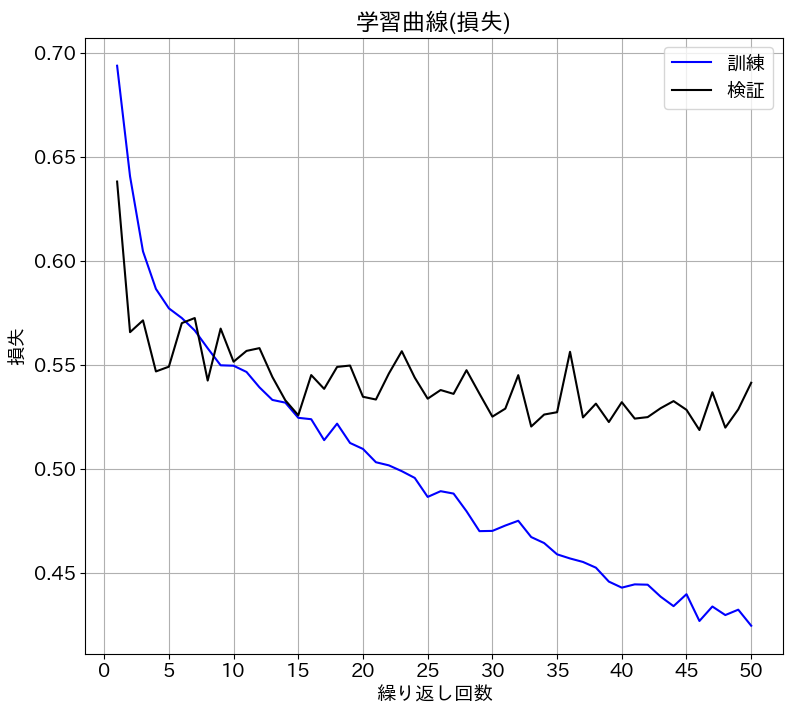

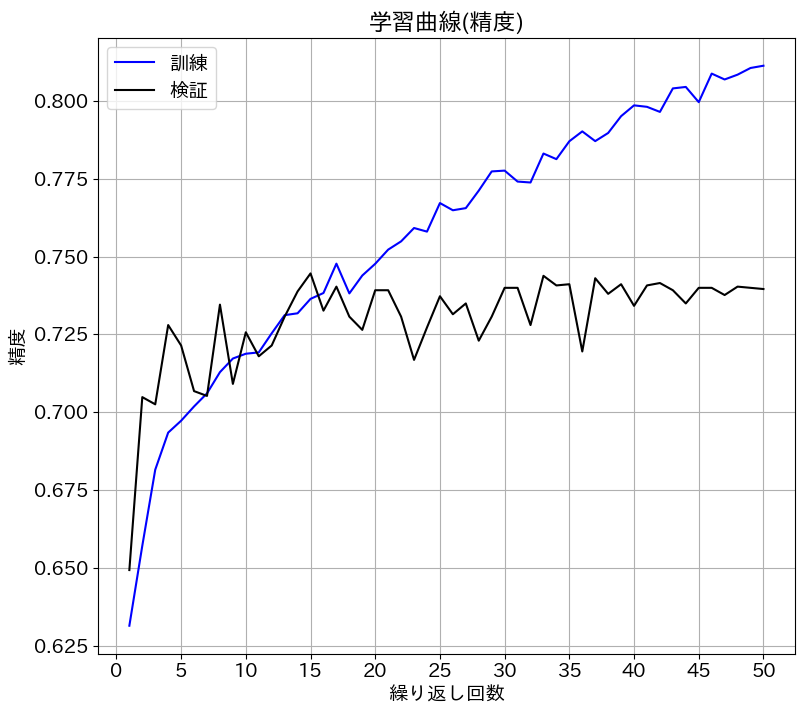

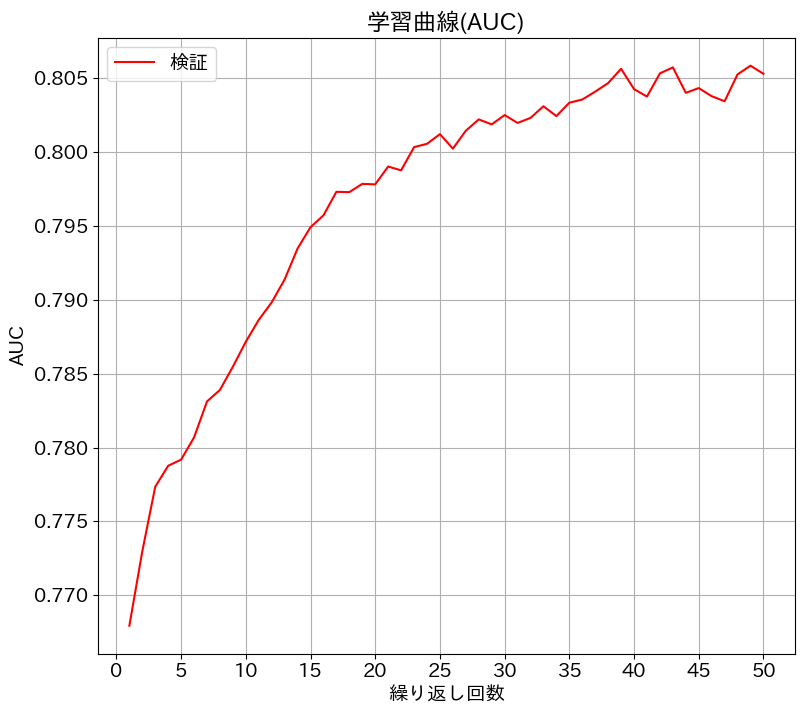

In [15]:
evaluate_history(each_history[0,:,:])

In [16]:
# np.save('../result/camel_3_cv_5_epoch_10.npy',each_history)

In [17]:
# np.save('../result/camel_3_cv_5_cv_hisotry.npy', cv_history)

In [18]:
# torch.save(net.state_dict(), '../model_weight.pth')

In [19]:
# cv_history = np.zeros((0,0,5))
# cv_history.shape

In [20]:
# cv_history = np.zeros((0,5))


In [21]:
# cv_cnt = 1
# num_epoch = 10
# each_history = np.zeros((0,num_epoch,5))
# history = np.zeros((0,5))
# item = np.arange(5).reshape(1,5)
# history = np.vstack((history, item))
# history
# history = np.arange(num_epoch*5).reshape((num_epoch,5))
# each_history = np.vstack((each_history, [history]))
# each_history

In [22]:
# history = np.arange(num_epoch*5).reshape((num_epoch,5))
# each_history = np.vstack((each_history, [history]))
# each_history

In [23]:
# history = np.zeros((0,5))
# history